In [107]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [108]:
def load_image(my_path):
    byte_img = tf.io.read_file(my_path)
    img = tf.io.decode_jpeg(byte_img)
    return img
    

In [109]:
fifty_images = tf.data.Dataset.list_files('/kaggle/input/traffic-data/traffic_data/50_data/*.JPG', shuffle=False).take(50)
fifty_images = fifty_images.map(load_image)
fifty_images = fifty_images.map(lambda x: tf.image.resize(x, (32, 32)))
fifty_images = fifty_images.map(lambda x: (x-127.5)/127.5)

In [110]:
len(fifty_images)

38

In [111]:
thirty_images = tf.data.Dataset.list_files('/kaggle/input/traffic-data/traffic_data/30_data/*.JPG', shuffle=False)
thirty_images = thirty_images.map(load_image)
thirty_images = thirty_images.map(lambda x: tf.image.resize(x, (32, 32)))
thirty_images = thirty_images.map(lambda x: x / 255)

In [112]:
len(thirty_images)

38

In [113]:
thirty_labels = tf.data.Dataset.from_tensor_slices(tf.ones(38))
thirty_labels

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.float32, name=None)>

In [114]:
fifty_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(38))
fifty_labels

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.float32, name=None)>

In [115]:
thirty=tf.data.Dataset.zip((thirty_images, thirty_labels))
fifty=tf.data.Dataset.zip((fifty_images, fifty_labels))
#dataset concatinate garna .concatenate use garni tesnor lai concatnate garna tf.concat....use garni
train = thirty.concatenate(fifty)

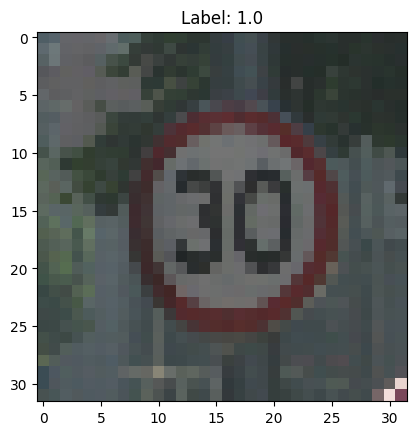

In [116]:
for elements in train.take(1):
    images,labels=elements
    plt.title(f'Label: {labels.numpy()}') 
    plt.imshow(images)

In [117]:
train_copy=train

In [118]:
while(len(train)<=60000):
    train = train.concatenate(train_copy)

  

In [119]:
len(train)

60040

In [120]:
batch_size=128
train = train.shuffle(6000)
train = train.batch(batch_size)
train = train.prefetch(8)

In [121]:
from tensorflow.keras.layers import Input, Embedding, Dense, Reshape, Concatenate, Conv2D, LeakyReLU, Flatten, Dropout,Conv2DTranspose
from tensorflow.keras.models import Model


In [122]:
def define_discriminator(in_shape=(32,32,3), n_classes=2):
	
    # label input
	in_label = Input(shape=(1,))  #Shape 1
	# embedding for categorical input
    #each label (total 10 classes for cifar), will be represented by a vector of size 50. 
    #This vector of size 50 will be learnt by the discriminator
	li = Embedding(n_classes, 10)(in_label) #Shape 1,50
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]  #32x32 = 1024. 
	li = Dense(n_nodes)(li)  #Shape = 1, 1024
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)  #32x32x1
    
    
	# image input
	in_image = Input(shape=in_shape) #32x32x3
	# concat label as a channel
	merge = Concatenate()([in_image, li]) #32x32x4 (4 channels, 3 for image and the other for labels)
    
	# downsample: This part is same as unconditional GAN upto the output layer.
    #We will combine input label with input image and supply as inputs to the model. 
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) #16x16x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #8x8x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)  #8192  (8*8*128=8192)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)  #Shape=1
    
	# define model
    ##Combine input label with input image and supply as inputs to the model. 
	model = Model([in_image, in_label], out_layer)
	# compile model
	
	return model


In [123]:
discriminator=define_discriminator()
discriminator.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 10)     │         20 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1, 1024)   │     11,264 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 32, 32, 1) │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32, 4) │          0 │ input_layer_9[0]… │
│ (Concatenate)       │                   │            │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │      4,736 │ concatenate_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ leaky_re_lu_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_11      │ (None, 8, 8, 128) │          0 │ conv2d_7[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 8192)      │          0 │ leaky_re_lu_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8192)      │          0 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │      8,193 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 171,797 (671.08 KB)

 Trainable params: 171,797 (671.08 KB)

 Non-trainable params: 0 (0.00 B)

In [124]:
def define_generator(latent_dim, n_classes=2):
    
    # Label input
    in_label = Input(shape=(1,))  # Input of dimension 1
    
    # Embedding for categorical input
    # Each label (total n_classes), will be represented by a vector of size 10. 
    li = Embedding(n_classes, 10)(in_label)  # Shape: (1, 10)
    
    # Linear multiplication
    n_nodes = 8 * 8  # To match the dimensions for concatenation later in this step.  
    li = Dense(n_nodes)(li)  # Shape: (1, 64)
    
    # Reshape to additional channel
    li = Reshape((8, 8, 1))(li)  # Shape: (8, 8, 1)
    
    # Image generator input
    in_lat = Input(shape=(latent_dim,))  # Input of dimension 100
    
    # Foundation for 8x8 image
    # We will reshape input latent vector into an 8x8 image as a starting point. 
    n_nodes = 128 * 8 * 8
    gen = Dense(n_nodes)(in_lat)  # Shape: (8192)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((8, 8, 128))(gen)  # Shape: (8, 8, 128)
    
    # Merge image gen and label input
    merge = Concatenate()([gen, li])  # Shape: (8, 8, 129)
    
    # Upsample to 16x16
    gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(merge)  # Shape: (16, 16, 128)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # Upsample to 32x32
    gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(gen)  # Shape: (32, 32, 128)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # Output
    out_layer = Conv2D(3, (8, 8), activation='tanh', padding='same')(gen)  # Shape: (32, 32, 3)
    
    # Define model
    model = Model([in_lat, in_label], out_layer)
    return model


In [125]:
generator=define_generator(100)
generator.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 8192)      │    827,392 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1, 10)     │         20 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_12      │ (None, 8192)      │          0 │ dense_11[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1, 64)     │        704 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 8, 8, 128) │          0 │ leaky_re_lu_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 8, 8, 1)   │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 8, 8, 129) │          0 │ reshape_8[0][0],  │
│ (Concatenate)       │                   │            │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 16, 16,    │    264,320 │ concatenate_5[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_13      │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 32, 32,    │    262,272 │ leaky_re_lu_13[0… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_14      │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32, 3) │     24,579 │ leaky_re_lu_14[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,379,287 (5.26 MB)

 Trainable params: 1,379,287 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [126]:
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [127]:
def discriminator_loss(real_output, fake_output):
    bce = BinaryCrossentropy(from_logits=True)

    #noise_real = 0.15*tf.random.uniform(tf.shape(real_output))
    #noise_fake = -0.15*tf.random.uniform(tf.shape(fake_output))



    real_labels = tf.ones_like(real_output)
    fake_labels = tf.zeros_like(fake_output)

    real_loss = bce(real_labels, real_output)
    fake_loss = bce(fake_labels, fake_output)

    total_loss = real_loss + fake_loss
    return total_loss


In [128]:
def generator_loss(fake_output):
    bce = BinaryCrossentropy(from_logits=True)
    t_loss = bce(tf.ones_like(fake_output), fake_output)
    return t_loss

In [129]:
g_loss=generator_loss
d_loss=discriminator_loss

In [130]:
from tensorflow.keras.models import Model
noise_dim=100

In [131]:
class trafficgan(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self,data):
        
        images,labels=data
        b=images.shape[0]
        noise=tf.random.normal([b,noise_dim])
        with tf.GradientTape() as d_tape:
            gen_images=self.generator([noise,labels],training=False)
            fake_output=self.discriminator([gen_images,labels],training=True)
            real_output=self.discriminator([images,labels],training=True)
            disc_loss=self.d_loss(real_output,fake_output)

        dgrad = d_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))


        with tf.GradientTape() as g_tape:
              gen_images=self.generator([noise,labels],training=True)
              fake_output=self.discriminator([gen_images,labels],training=False)
              gen_loss=self.g_loss(fake_output)

        ggrad = g_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"discriminator_loss":disc_loss, "generator_loss":gen_loss}

In [132]:
traffic=trafficgan(generator,discriminator)

In [133]:
g_opt = Adam(0.0002,0.5)
d_opt = Adam(0.0002,0.5)
#0.0002,0.5

In [134]:
traffic.compile(g_opt,d_opt,g_loss,d_loss,run_eagerly=True)

In [135]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [136]:
class ModelMonitor(Callback):
    def __init__(self, num_img=1, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):

        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator([random_latent_vectors, tf.ones((self.num_img, 1))], training=False)
        generated_images *= 255
        generated_images = generated_images.numpy().astype(np.uint8)
        for i in range(self.num_img):
            img = generated_images[i]

            # Save image using cv2.imwrite
            save_path = f'/kaggle/working/generated_img_{epoch}_{i}.png'
            cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

In [137]:
hist = traffic.fit(train, epochs=10,callbacks=[ModelMonitor()])

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:674: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


470/470 ━━━━━━━━━━━━━━━━━━━━ 142s 276ms/step - discriminator_loss: 1.0041 - generator_loss: 1.1861
Epoch 2/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 135s 277ms/step - discriminator_loss: 1.1375 - generator_loss: 1.0149
Epoch 3/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 134s 274ms/step - discriminator_loss: 1.2308 - generator_loss: 0.8372
Epoch 4/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 135s 275ms/step - discriminator_loss: 1.1447 - generator_loss: 0.8931
Epoch 5/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 134s 275ms/step - discriminator_loss: 1.0462 - generator_loss: 0.9955
Epoch 6/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 134s 275ms/step - discriminator_loss: 0.9516 - generator_loss: 1.1174
Epoch 7/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 135s 276ms/step - discriminator_loss: 0.8860 - generator_loss: 1.2277
Epoch 8/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 135s 276ms/step - discriminator_loss: 0.8248 - generator_loss: 1.3293
Epoch 9/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 135s 276ms/step - discriminator_loss: 0.7769 - generator_loss: 1.4344
Epoch 10/10
470/470 ━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


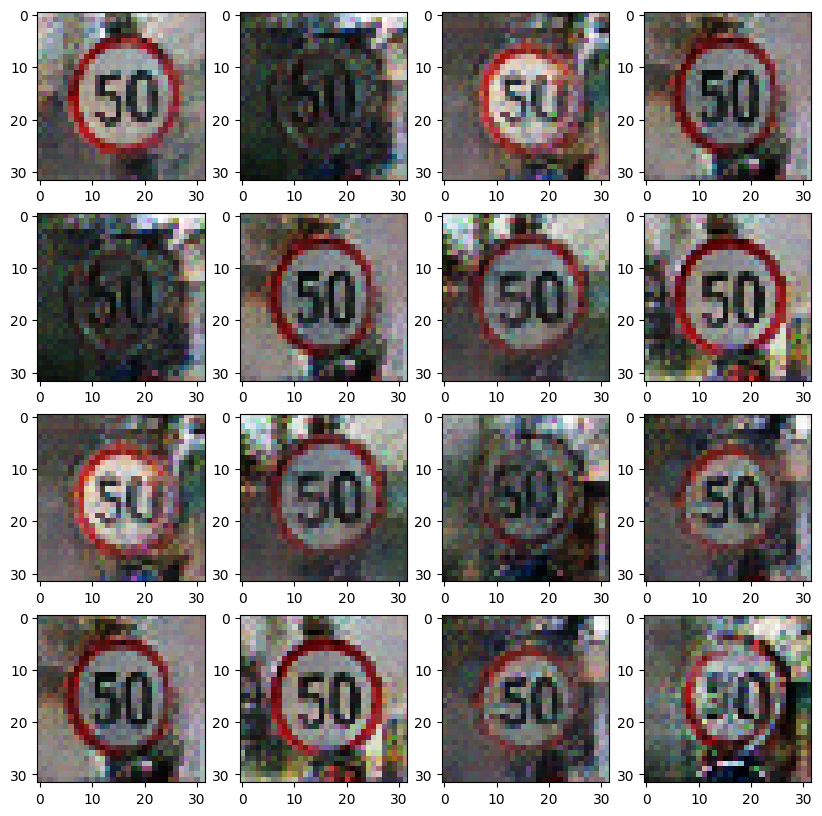

In [144]:
imgs = generator.predict([tf.random.normal((16, 100)),tf.zeros((16, 1))])

def rescale_images(images):
    return (images + 1) / 2  # Rescale from [-1, 1] to [0, 1]


img_rescaled = rescale_images(imgs)

fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(img_rescaled[(r+1)*(c+1)-1])
#plt.savefig('/content/drive/My Drive/generated_grid.png')

In [143]:
generator.save('/kaggle/working/congeneratortwo.h5')